

<img src='data/img/logo.gif' width=400>

# Хакатон. Задача от `B`e`e`l`i`n`e`

##### `Задача`: необходимо создать модель для бинарной классификации аудиофрагментов с целью определения качества их транскрибации.

___
# <center> <a style='color:gold'>Классические модели</a>
___
### <a id=100 style='color:gold'>Содержание</a>

[Предобработка данных](#555)
- [Импорт данных](#1)
- [Получение эмбеддингов](#2)
- [Предобработка данных для обучения моделей](#3)
- [Сбор параметров, метрик и визуализация](#4)

[Обучение моделей](#5)
- Linear models
    - [LogisticRegression](#6)
    - [SGDClassifier](#7)
- SVM
    - [SVC](#8)
    - [NuSVC](#9)
- Neighbors
    - [KNeighborsClassifier](#10)
    - [RadiusNeighborsClassifier](#11)
- Discriminant analysis
    - [LinearDiscriminantAnalysis](#12)
    - [QuadraticDiscriminantAnalysis](#13)
- Naive bayes
    - [GaussianNB](#14)
    - [BernoulliNB](#15)
- Gaussian process
    - [GaussianProcessClassifier](#16)
- Ensemble
    - [XGBClassifier](#17)
    - [HistGradientBoostingClassifier](#18)
    - [ExtraTreesClassifier](#19)
    - [LGBMClassifier](#20)
    - [StackingClassifier](#21)
- Neural network
    - [MLPClassifier](#22)




___
## <center> <a id=1 style='color:gold'>Импорт данных</a>

### Импорт библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import torch
from pytorch_lightning import seed_everything
from tqdm import trange
from transformers import AutoTokenizer, AutoModel
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier


seed_everything(42)
np.random.seed(42)

Seed set to 42


### Исходный датафрейм

In [2]:
FILE_PATH = 'data/hackaton_result_dataset.xlsx'

df = pd.read_excel(FILE_PATH)
df[:3]

,model_annotation,human_markup,audio_path,label
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,s3://ap-training-set/xacaton_openstt/part_1/05...,1
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,s3://ap-training-set/xacaton_openstt/part_1/05...,0
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,s3://ap-training-set/xacaton_openstt/part_1/05...,0


___
## <center> <a id=2 style='color:gold'>Получение эмбеддингов</a>

### Импорт модели и токенизатора SBERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru",**{'padding':True, 'truncation':True, 'max_length':24, 'return_tensors':'pt'})
model = AutoModel.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")

In [4]:
def mean_pooling(tokens, attention_mask):
    with torch.no_grad():
        output = model(**tokens)
    token_embeddings = output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

### Токенизация

In [5]:
df['tokens'] = df['model_annotation'].apply(lambda x: tokenizer(x, padding=True, truncation=True, max_length=24, return_tensors='pt'))

### Эмбеддинги

In [ ]:
from tqdm import tqdm


tqdm.pandas()
df['emb'] = df['tokens'].progress_apply(lambda token: mean_pooling(token, token['attention_mask']))

In [273]:
df['emb'][:3]

0    [[tensor(-0.3775), tensor(0.0096), tensor(-0.0...
1    [[tensor(-0.3522), tensor(-0.1911), tensor(0.9...
2    [[tensor(-0.2016), tensor(0.1401), tensor(-0.6...
Name: emb, dtype: object

### Сохранение датафрейма

In [20]:
# df.to_pickle('data/df_emb.pkl')

### Загрузка датафрейма

In [2]:
df = pd.read_pickle('data/df_emb.pkl')

___
## <center> <a id=3 style='color:gold'>Предобработка данных для обучения моделей</a>

### Разделение выборки

In [3]:
X = df['emb']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [4]:
X_train_ser = X_train.apply(lambda x: torch.reshape(x, shape=(1024,)).numpy())
X_test_ser = X_test.apply(lambda x: torch.reshape(x, shape=(1024,)).numpy())
y_train_arr = y_train.to_numpy()
y_test_arr = y_test.to_numpy()

### Series -> array

In [5]:

def get_matrix(X: pd.Series) -> np.ndarray:
    X_train_matrix = np.zeros((X.shape[0], 1024))
    for i, array in enumerate(X):
        X_train_matrix[i] = array

    return X_train_matrix

X_train_matrix = get_matrix(X_train_ser)
X_test_matrix = get_matrix(X_test_ser)

___
## <center> <a id=4 style='color:gold'>Сбор параметров, метрик и визуализация</a>

- auc test
- Визуализация roc-auc

In [6]:
def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, best_params=True):
    out_dict = {}
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
            print('NN roc-auc computed')
        else:
            raise ValueError('Unrecognized model type')
        
        auc = roc_auc_score(y, proba)

        out_dict[f'{model_name}_{data_name}'] = auc
        
        ax = plt.subplot()
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))
    if isinstance(model, BaseEstimator):
        if best_params:
            out_dict['best_params'] = model.best_params_
            
    plt.style.use('ggplot');
    ax.plot([0, 1], [0, 1], '--', color='black',)
    ax.legend(fontsize='large')
    ax.set_title(model_name)
    
    pickle.dump(out_dict, open(f'data/results/{model_name}.pkl', 'wb'))
    
    return out_dict

- mean auc train
- mean auc validation
- mean test std auc validation

In [7]:
def get_metrics(gs, out_dict: dict) -> dict:
    """Сбор параметров и метрик обученной модели

    Args:
        gs (_type_): Экземпляр класса GridSearchCV после обучения
        out_dict (dict): Словарь с метриками на тесте и лучшими параметрами модели

    Returns:
        dict: Обновленный словарь со средними метриками на обучающей и валидационной выборках
    """
    
    val_auc = gs.best_score_
    metrics_df = pd.DataFrame(gs.cv_results_)
    total_main_metrics = metrics_df[['mean_train_score', 'mean_test_score', 'std_test_score']]
    main_metrics_dict = total_main_metrics[total_main_metrics['mean_test_score'] == val_auc].to_dict()
    out_dict.update(**main_metrics_dict)
    return out_dict

___
## <center> <a id=5 style='color:gold'>Обучение моделей</a>

### <a id=6 style='color:gold'>LogisticRegression</a>

- `L1`

c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'log_reg_sbert_l1_train': 0.8273777144217085,
 'log_reg_sbert_l1_test': 0.8009431181844975,
 'best_params': {'C': 0.2,
  'max_iter': 3,
  'penalty': 'l1',
  'solver': 'liblinear'},
 'mean_train_score': {0: 0.8318348997628146},
 'mean_test_score': {0: 0.7805305901535281},
 'std_test_score': {0: 0.009653528504447126}}

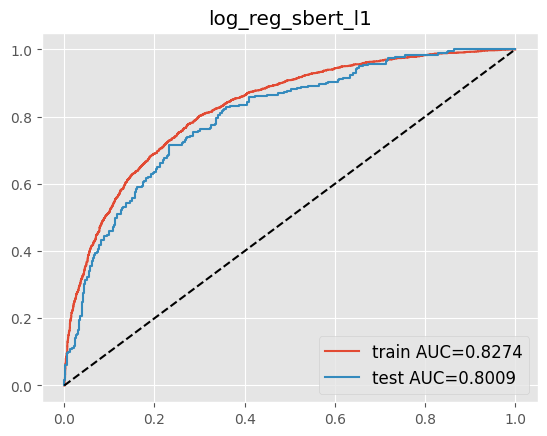

In [21]:
lr = LogisticRegression(random_state=1)

param_grid = {'penalty': ['l1'],
                'solver':['liblinear'],
                'max_iter': [3, 4, 5],
                'C':[0.2, 0.3, 0.4]}
gs = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'log_reg_sbert_l1', X_train_matrix, X_test_matrix, y_train, y_test)
lr_l1_dict = get_metrics(gs, out_dict)
lr_l1_dict

- `L2`

c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'log_reg_sbert_l2_train': 0.8038216823464843,
 'log_reg_sbert_l2_test': 0.7992238923273406,
 'best_params': {'C': 0.6, 'max_iter': 8, 'penalty': 'l2', 'solver': 'lbfgs'},
 'mean_train_score': {50: 0.8077353003057162},
 'mean_test_score': {50: 0.7751085801753516},
 'std_test_score': {50: 0.008705929158829387}}

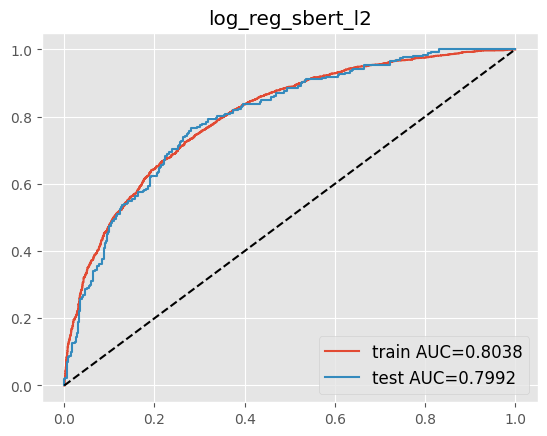

In [22]:
lr = LogisticRegression()

param_grid = {'penalty': ['l2'],
                'solver':['saga', 'liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
                'max_iter': [ 6, 7, 8],
                'C':[ 0.4, 0.5, 0.6]}
gs = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_matrix, y_train_arr)


out_dict = visualize_and_save_results(gs, 'log_reg_sbert_l2', X_train_matrix, X_test_matrix, y_train, y_test)
lr_l2_dict = get_metrics(gs, out_dict)
lr_l2_dict

- `Elastic net`

c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'log_reg_sbert_elnet_train': 0.8385314316798693,
 'log_reg_sbert_elnet_test': 0.8063463994498478,
 'mean_train_score': {2: 0.8416891494795067},
 'mean_test_score': {2: 0.7791058614703548},
 'std_test_score': {2: 0.011228703892730382}}

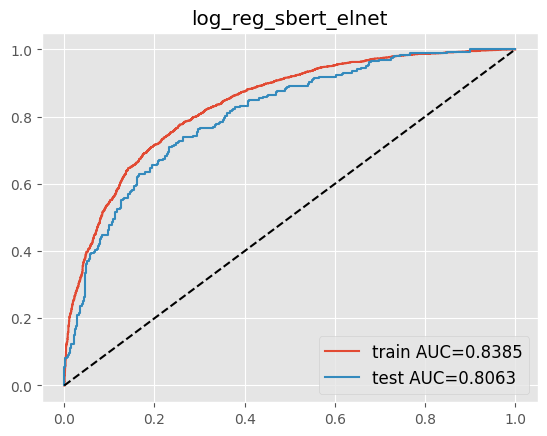

In [23]:
lr = LogisticRegression()

param_grid = {'penalty': ['elasticnet'],
                'solver':['saga'],
                'max_iter': [  7 ],
                'C':[ 0.2, 0.3, 0.4],
                'l1_ratio':[0.8, 0.9, 1]}
gs = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'log_reg_sbert_elnet', X_train_matrix, X_test_matrix, y_train, y_test)
lr_elnet_dict = get_metrics(gs, out_dict)
lr_elnet_dict

### <a id=7 style='color:gold'>SGDClassifier</a>

{'sgd_sbert_train': 0.8242403747614029,
 'sgd_sbert_test': 0.8073681108163867,
 'best_params': {'alpha': 0.04,
  'eta0': 0.01,
  'learning_rate': 'adaptive',
  'loss': 'log_loss',
  'max_iter': 5000,
  'penalty': 'l2'},
 'mean_train_score': {10: 0.8303445122740767},
 'mean_test_score': {10: 0.7818236047222693},
 'std_test_score': {10: 0.010532022459976573}}

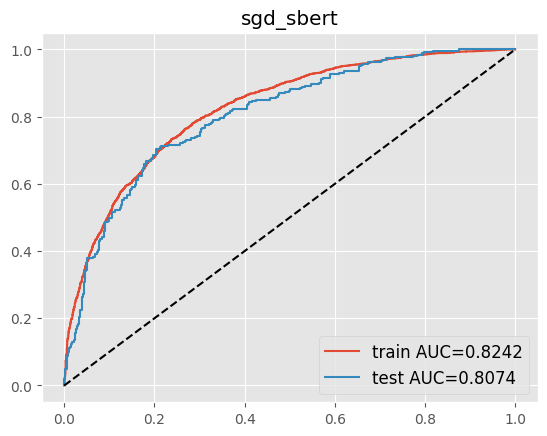

In [55]:
sgd = SGDClassifier(random_state=1, n_jobs=2)

param_grid = {
            'penalty':[ 'l2'],
            'alpha': [0.05, 0.03, 0.04],
            'learning_rate':['adaptive', 'optimal'],
            'loss':['log_loss'],
            'eta0':[0.007, 0.01],
            'max_iter':[5000]
            }

gs = GridSearchCV(estimator=sgd, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'sgd_sbert', X_train_matrix, X_test_matrix, y_train, y_test)
sgd_dict = get_metrics(gs, out_dict)
sgd_dict

### <a id=8 style='color:gold'>SVC</a>

[LibSVM]

{'svc_sbert_train': 0.9989930351496665,
 'svc_sbert_test': 0.6531486393555359,
 'best_params': {'C': 1.5, 'gamma': 0.1, 'kernel': 'rbf'},
 'mean_train_score': {9: 0.9987784554429016},
 'mean_test_score': {9: 0.6435854386364991},
 'std_test_score': {9: 0.011533970426091078}}

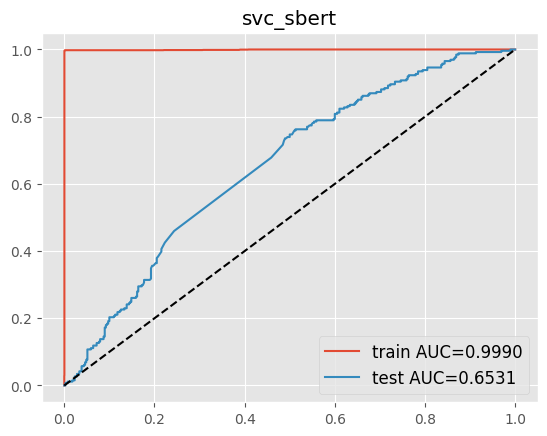

In [56]:
svc = SVC(probability=True, verbose=1)

param_grid = {'C': [0.5, 1, 1.5],
            'kernel': ['rbf'],
            'gamma':[0, 0.1, 0.5, 1]
            }

gs = GridSearchCV(estimator=svc, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'svc_sbert', X_train_matrix, X_test_matrix, y_train, y_test)
svc_dict = get_metrics(gs, out_dict)
svc_dict

### <a id=9 style='color:gold'>NuSVC</a>

Параметр nu в NuSVC определяет количество опорных векторов.  
- При nu = 1 NuSVC эквивалентен стандартному методу опорных векторов (SVC). 
- При nu < 1 NuSVC становится менее строгим в выборе опорных векторов и может быть более толерантным к ошибкам. 
- При nu > 1 NuSVC становится более строгим в выборе опорных векторов и может стремиться к идеальной классификации.

-  `linear` kernel
-  `rbf` kernel

{'nusvc_sbert_rbf_train': 0.995324407089188,
 'nusvc_sbert_rbf_test': 0.8023086747224679,
 'best_params': {'kernel': 'rbf', 'nu': 0.5},
 'mean_train_score': {0: 0.9964952599438857},
 'mean_test_score': {0: 0.7755506246472468},
 'std_test_score': {0: 0.008777923774870659}}

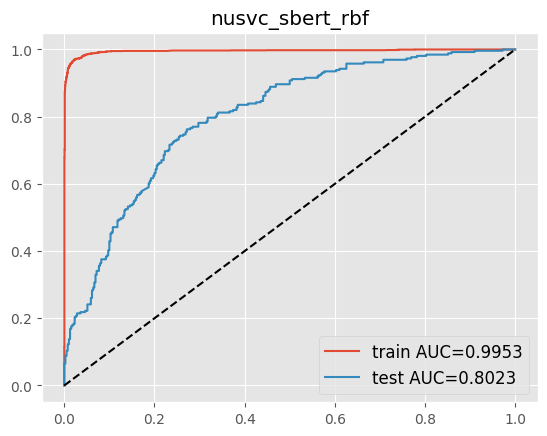

In [57]:
nusvc = NuSVC(probability=True)

param_grid = {'nu': [0.1, 0.5, 1.5, 2],
            'kernel': ['linear', 'rbf'],
            }

gs = GridSearchCV(estimator=nusvc, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'nusvc_sbert_rbf', X_train_matrix, X_test_matrix, y_train, y_test)
NuSVC_dict = get_metrics(gs, out_dict)
NuSVC_dict

- `poly` kernel
- `sigmoid` kernel

{'nusvc_sbert_train': 0.8528685080940885,
 'nusvc_sbert_test': 0.8133215443560271,
 'best_params': {'coef0': 1, 'degree': 3, 'kernel': 'poly', 'nu': 0.7},
 'mean_train_score': {0: 0.8629897633276549},
 'mean_test_score': {0: 0.7803629177549051},
 'std_test_score': {0: 0.008923447303814}}

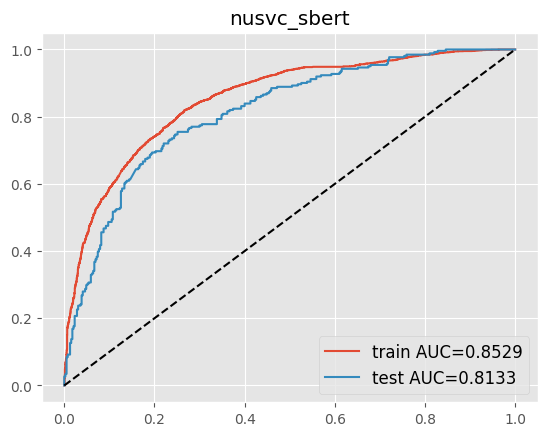

In [58]:
nusvc = NuSVC(probability=True)

param_grid = {'nu': [0.3, 0.5, 0.7],
            'kernel': ['poly', 'sigmoid'],
            'degree': [3, 4, 5],
            'coef0':[0, 0.5, 1],
            }

gs = GridSearchCV(estimator=nusvc, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'nusvc_sbert', X_train_matrix, X_test_matrix, y_train, y_test)
NuSVC_poly_dict = get_metrics(gs, out_dict)
NuSVC_poly_dict

### <a id=10 style='color:gold'>KNeighborsClassifier</a>

- `brute` algorithm

{'knn_sbert_train': 0.9999909539513626,
 'knn_sbert_test': 0.7031240789861479,
 'best_params': {'algorithm': 'brute',
  'metric': 'l1',
  'n_neighbors': 5,
  'weights': 'distance'},
 'mean_train_score': {1: 0.9999919937327892},
 'mean_test_score': {1: 0.6880332509162046},
 'std_test_score': {1: 0.012544897878744517}}

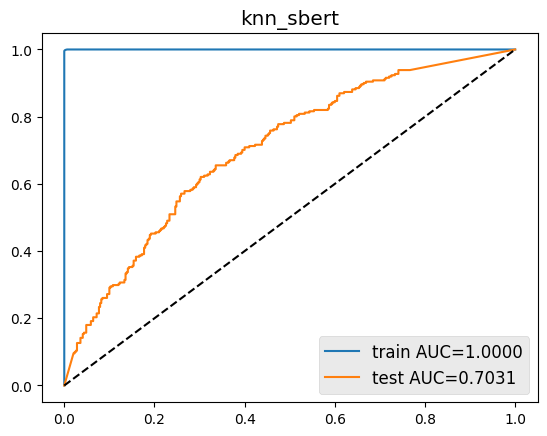

In [12]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [ 4, 5],
            'weights': [ 'distance'],
            'algorithm': ['brute'],
            'metric':['l1'],
            }

gs = GridSearchCV(estimator=knn, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'knn_sbert', X_train_matrix, X_test_matrix, y_train, y_test)
knn_dict = get_metrics(gs, out_dict)
knn_dict

- `tree` algorithm

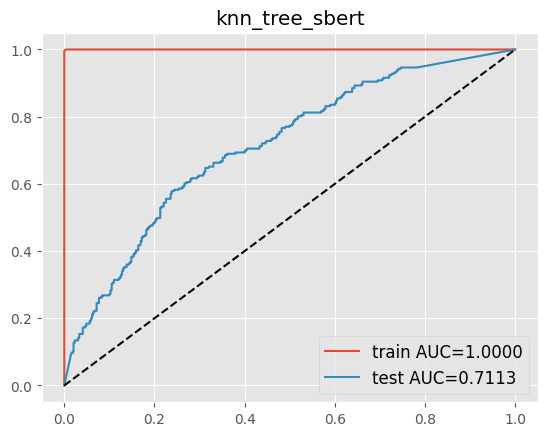

In [14]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [5],
            'weights': [ 'distance'],
            'algorithm': ['ball_tree'],
            }

gs = GridSearchCV(estimator=knn, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'knn_tree_sbert', X_train_matrix, X_test_matrix, y_train, y_test)

### <a id=11 style='color:gold'>RadiusNeighborsClassifier</a>

{'rnn_sbert_train': 0.726194381978814,
 'rnn_sbert_test': 0.7588368209057864,
 'best_params': {'metric': 'l2', 'radius': 23},
 'mean_train_score': {0: 0.727373068931796},
 'mean_test_score': {0: 0.7046970371008078},
 'std_test_score': {0: 0.011145606752305876}}

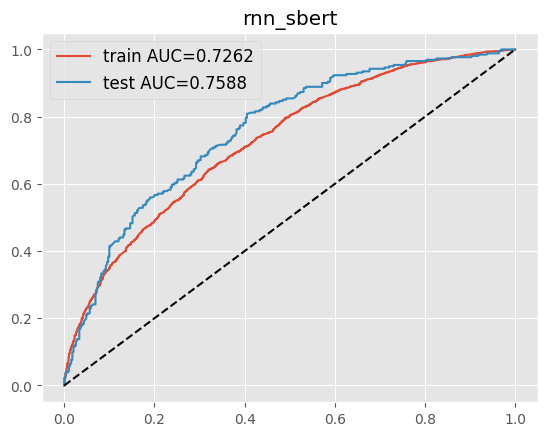

In [16]:
rnn = RadiusNeighborsClassifier()

param_grid = {
            'radius':[23],
            'metric':['l2']
            }

gs = GridSearchCV(estimator=rnn, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'rnn_sbert', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
rnn_dict = get_metrics(gs, out_dict)
rnn_dict

### <a id=12 style='color:gold'>LinearDiscriminantAnalysis</a>

{'lda_sbert_train': 0.8255967963631242,
 'lda_sbert_test': 0.8090087434915021,
 'best_params': {'shrinkage': 0.345, 'solver': 'lsqr'},
 'mean_train_score': {2: 0.8319287535067875, 3: 0.8319287535067875},
 'mean_test_score': {2: 0.7825123151517495, 3: 0.7825123151517495},
 'std_test_score': {2: 0.009824102234281193, 3: 0.009824102234281193}}

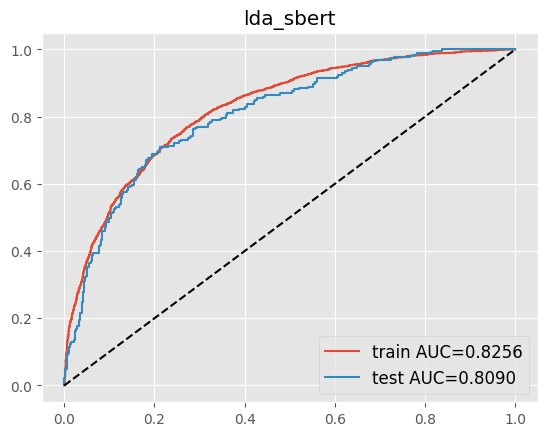

In [18]:
lda = LinearDiscriminantAnalysis()

param_grid = {
            'solver': [ 'lsqr', 'eigen'],
            'shrinkage':[0.343,0.345, 0.344, ],
            }

gs = GridSearchCV(estimator=lda, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'lda_sbert', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
lda_dict = get_metrics(gs, out_dict)
lda_dict

### <a id=13 style='color:gold'>QuadraticDiscriminantAnalysis</a>

c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'qda_sbert_train': 0.8218502751455866,
 'qda_sbert_test': 0.7873661459868355,
 'best_params': {'reg_param': 0.9},
 'mean_train_score': {3: 0.8372551056773139},
 'mean_test_score': {3: 0.7394529652188725},
 'std_test_score': {3: 0.014317358527579625}}

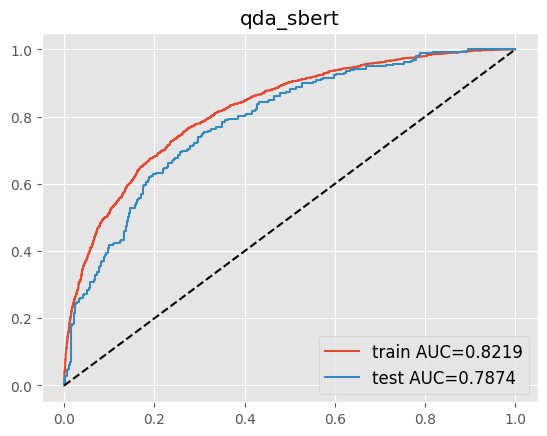

In [20]:
qda = QuadraticDiscriminantAnalysis()

param_grid = {
            'reg_param':[ 1, 0.99, 0.7, 0.9]
            }

gs = GridSearchCV(estimator=qda, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'qda_sbert', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
qda_dict = get_metrics(gs, out_dict)
qda_dict

### <a id=14 style='color:gold'>GaussianNB</a>

{'gnb_sbert_train': 0.7355470855938336,
 'gnb_sbert_test': 0.749651242754691,
 'best_params': {'var_smoothing': 0.14},
 'mean_train_score': {0: 0.7382709644793681},
 'mean_test_score': {0: 0.7221023938227394},
 'std_test_score': {0: 0.01595208002376791}}

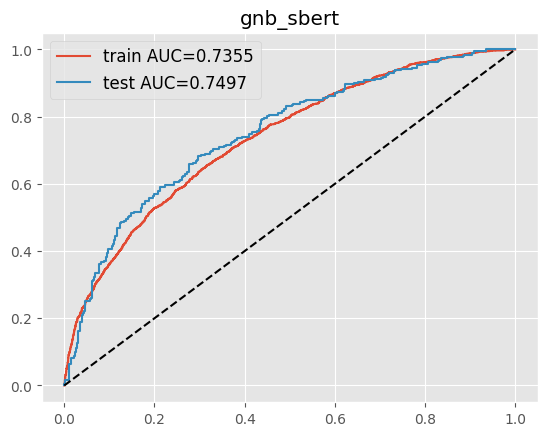

In [21]:
gnb = GaussianNB()

param_grid = {'var_smoothing': [0.14, 0.15],
            }

gs = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', return_train_score=True)

X_train_comp = X_train_matrix.clip(0) 
X_test_comp = X_test_matrix.clip(0)
gs.fit(X_train_comp, y_train_arr)

out_dict = visualize_and_save_results(gs, 'gnb_sbert', X_train_comp, X_test_matrix, y_train, y_test, out_dict)
gnb_dict = get_metrics(gs, out_dict)
gnb_dict

### <a id=15 style='color:gold'>BernoulliNB</a>

{'bnb_sbert_train': 0.7391260424205042,
 'bnb_sbert_test': 0.7492779251399941,
 'best_params': {'alpha': 0, 'binarize': 0.5, 'force_alpha': True},
 'mean_train_score': {1: 0.7430936776531369},
 'mean_test_score': {1: 0.7203606444769053},
 'std_test_score': {1: 0.014188239691101468}}

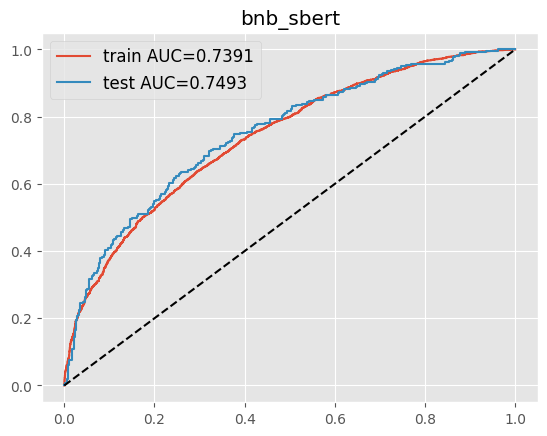

In [22]:
bnb = BernoulliNB()

param_grid = {
    'alpha': [0, 1, 0.5],
    'binarize':[0.4, 0.5, 0.6],
    'force_alpha': [True]
            }

gs = GridSearchCV(estimator=bnb, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', return_train_score=True)

X_train_comp = X_train_matrix.clip(0) 
X_test_comp = X_test_matrix.clip(0)
gs.fit(X_train_comp, y_train_arr)

out_dict = visualize_and_save_results(gs, 'bnb_sbert', X_train_comp, X_test_matrix, y_train, y_test, out_dict)
bnb_dict = get_metrics(gs, out_dict)
bnb_dict

### <a id=16 style='color:gold'>GaussianProcessClassifier</a>

$K(x_i, x_j) = exp(-\gamma ||x_i - x_j||^2)$, где 
- $x_i$ и $x_j$ — векторы признаков двух объектов, 
- $\gamma$ — параметр, который определяет ширину функции ядра. 

Чем больше значение $\gamma$, тем более «гладкой» будет поверхность принятия решений модели.

{'gauss_sbert_train': 0.8630731794978898,
 'gauss_sbert_test': 0.8009234698889871,
 'best_params': {'kernel': 1**2 * RBF(length_scale=2)},
 'mean_train_score': {0: 0.8621711554085879},
 'mean_test_score': {0: 0.7754691143929164},
 'std_test_score': {0: 0.010021230265522062}}

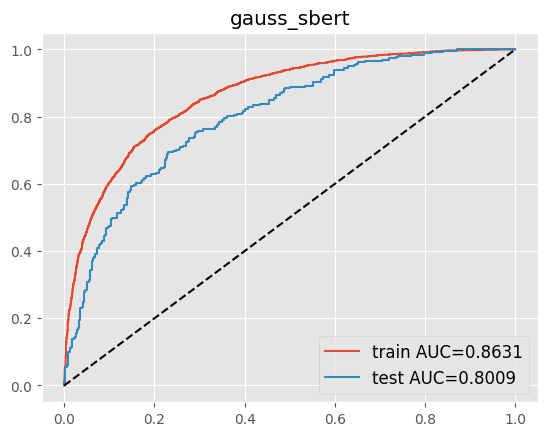

In [23]:
gauss = GaussianProcessClassifier()
kernel = 1 * RBF(2)
param_grid = {
    'kernel': [kernel],
            }

gs = GridSearchCV(estimator=gauss, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', return_train_score=True)

X_train_comp = X_train_matrix.clip(0) 
X_test_comp = X_test_matrix.clip(0)
gs.fit(X_train_comp, y_train_arr)

out_dict = visualize_and_save_results(gs, 'gauss_sbert', X_train_comp, X_test_matrix, y_train, y_test, out_dict)
gauss_dict = get_metrics(gs, out_dict)
gauss_dict

### <a id=17 style='color:gold'>XGBClassifier</a>

{'xgb_sbert_train': 0.855754744015037,
 'xgb_sbert_test': 0.7985558502799882,
 'best_params': {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 300},
 'mean_train_score': {1: 0.8697046384375906},
 'mean_test_score': {1: 0.7574035824624984},
 'std_test_score': {1: 0.01484710057414144}}

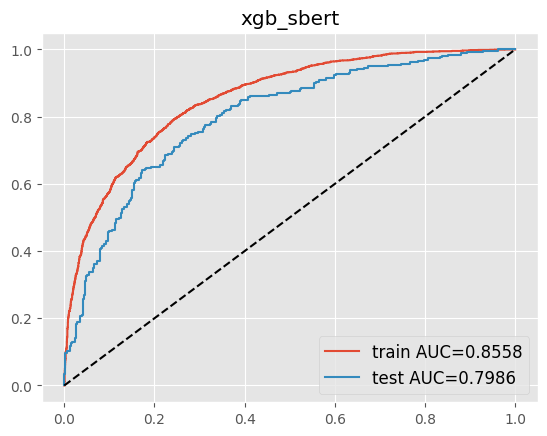

In [24]:
xgb = XGBClassifier()

param_grid = {'learning_rate': [0.25, 0.2, 0.1, 0.15],
            'max_depth': [1],
            'n_estimators': [300]}

gs = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)


out_dict = visualize_and_save_results(gs, 'xgb_sbert', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
xgb_dict = get_metrics(gs, out_dict)
xgb_dict

### <a id=18 style='color:gold'>HistGradientBoostingClassifier</a>

{'hist_sbert_train': 0.9449450194520401,
 'hist_sbert_test': 0.7897534138913451,
 'best_params': {'l2_regularization': 1,
  'learning_rate': 0.15,
  'loss': 'log_loss',
  'max_depth': 3,
  'max_iter': 100,
  'min_samples_leaf': 17},
 'mean_train_score': {6: 0.9629355540631241},
 'mean_test_score': {6: 0.7624194639120012},
 'std_test_score': {6: 0.01352749605858188}}

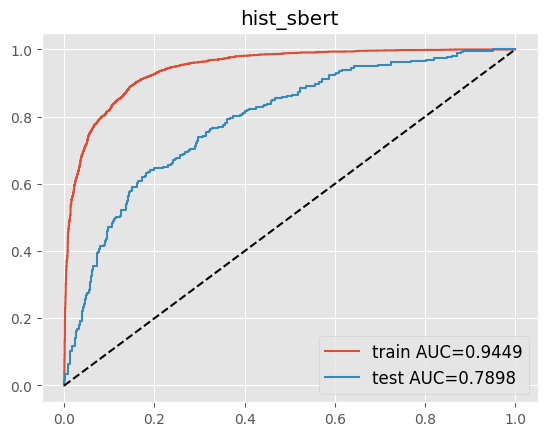

In [27]:
hist = HistGradientBoostingClassifier()

param_grid = {'learning_rate': [0.1, 0.15, 0.2],
            'max_depth': [ 2, 3],
            'loss': ['log_loss'],
            'max_iter':[100],
            'min_samples_leaf':[17, 20],
            'l2_regularization':[1, 0.1, 0]}

gs = GridSearchCV(estimator=hist, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'hist_sbert', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
hist_dict = get_metrics(gs, out_dict)
hist_dict

### <a id=19 style='color:gold'>ExtraTreesClassifier</a>

{'extree_sbert_train': 0.7650840736117654,
 'extree_sbert_test': 0.7559976422045388,
 'best_params': {'bootstrap': True,
  'criterion': 'log_loss',
  'max_depth': 3,
  'max_features': 'sqrt',
  'n_estimators': 240},
 'mean_train_score': {32: 0.7798107489754441},
 'mean_test_score': {32: 0.7255029249530428},
 'std_test_score': {32: 0.0138917348874}}

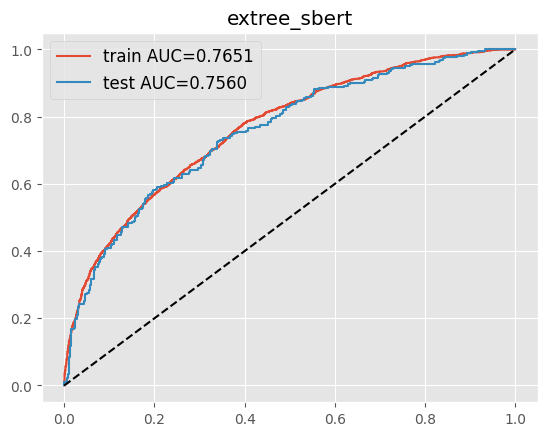

In [39]:
extree = ExtraTreesClassifier()

param_grid = {
            'n_estimators':[245, 235, 240],
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_depth':[2, 3],
            'bootstrap':[True, False],
            'max_features':['sqrt', 'log2']
            }

gs = GridSearchCV(estimator=extree, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'extree_sbert', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
extree_dict = get_metrics(gs, out_dict)
extree_dict

### <a id=20 style='color:gold'>LGBMClassifier</a>

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] 0.1 is set=, 0.1= will be ignored. Current value: 0.1=
[LightGBM] [Warning] 0.1 is set=, 0.1= will be ignored. Current value: 0.1=
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] 0.1 is set=, 0.1= will be ignored. Current value: 0.1=
[LightGBM] [Warning] 0.1 is set=, 0.1= will be ignored. Current value: 0.1=
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] U

{'lgbm_sbert_train': 0.8223043989295307,
 'lgbm_sbert_test': 0.787061597406425,
 'best_params': {'boosting_type': 'gbdt',
  'learning_rate ': 0.1,
  'max_depth': 1,
  'n_estimators': 300,
  'reg_alpha ': 0.1,
  'reg_lambda ': 0.1},
 'mean_train_score': {0: 0.8342841190196524,
  1: 0.8342841190196524,
  2: 0.8342841190196524,
  3: 0.8342841190196524},
 'mean_test_score': {0: 0.7522537843040592,
  1: 0.7522537843040592,
  2: 0.7522537843040592,
  3: 0.7522537843040592},
 'std_test_score': {0: 0.015063966653595814,
  1: 0.015063966653595814,
  2: 0.015063966653595814,
  3: 0.015063966653595814}}

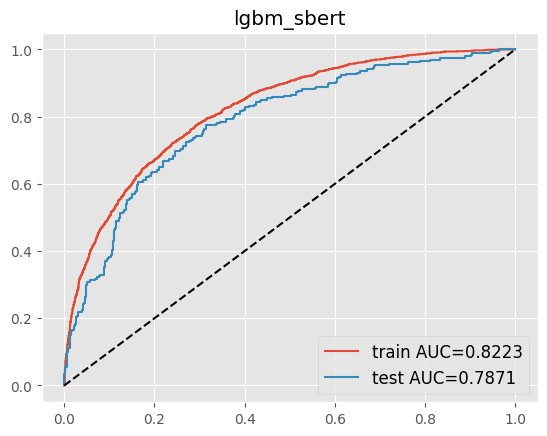

In [53]:
lgbm = LGBMClassifier(objective='binary')
lgbm.set_params(verbose=0)

param_grid = {
            'boosting_type':['gbdt'],
            'max_depth': [1],
            'learning_rate ': [0.1],
            'reg_alpha ':[0.1, 0.5],
            'reg_lambda ':[0.1, 0.5],
            'n_estimators' :[300]
            }

gs = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)


out_dict = visualize_and_save_results(gs, 'lgbm_sbert', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
lgbm_dict = get_metrics(gs, out_dict)
lgbm_dict

### <a id=21 style='color:gold'>StackingClassifier</a>

{'stck_sbert_train': 0.8498058438688432,
 'stck_sbert_test': 0.8022202573926712,
 'mean_train_score': {0: 0.8611275205786582},
 'mean_test_score': {0: 0.7725362958670108},
 'std_test_score': {0: 0.008765905954818663}}

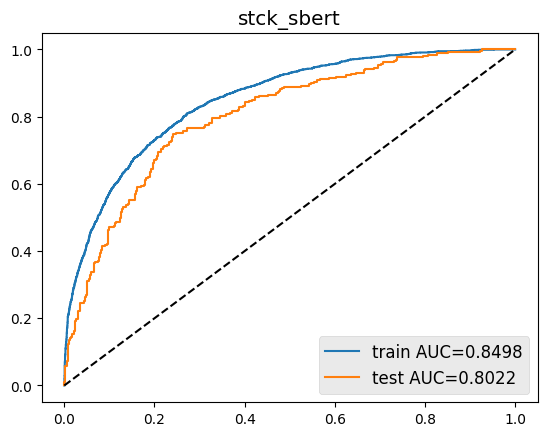

In [8]:
params_mlp = {'activation': 'relu',
  'early_stopping': True,
  'hidden_layer_sizes': (4, 8, 16, 24),
  'learning_rate': 'adaptive',
  'learning_rate_init': 0.0002,
  'max_iter': 300,
  'solver': 'adam'}

params_sgd = {
            'penalty':'l1',
            'learning_rate':'adaptive',
            'loss':'log_loss',
            'eta0':0.099,
            'max_iter':5000
            }

params_et = {
  'criterion': 'log_loss',
  'max_depth': 5,
  'max_features': 'sqrt',
  'n_estimators': 100
  }

estimators = [
('et', ExtraTreesClassifier(**params_et, random_state=1)),
('mlp', MLPClassifier(**params_mlp, random_state=1)),
('sgd', SGDClassifier(**params_sgd, random_state=1)),
]

param_grid={}
clf = StackingClassifier(estimators=estimators, final_estimator=SGDClassifier(loss='log_loss', random_state=1), cv=5, n_jobs=-1, stack_method='auto')

gs = GridSearchCV(estimator=clf, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'stck_sbert', X_train_matrix, X_test_matrix, y_train, y_test, best_params=False)
stck_dict = get_metrics(gs, out_dict)
stck_dict

### <a id=22 style='color:gold'>MLPClassifier</a>

{'mlp_sbert_train': 0.8179833018441797,
 'mlp_sbert_test': 0.8039100108065627,
 'best_params': {'activation': 'relu',
  'early_stopping': True,
  'hidden_layer_sizes': (4, 8, 16, 24),
  'learning_rate': 'adaptive',
  'learning_rate_init': 0.0002,
  'max_iter': 300,
  'solver': 'adam'},
 'mean_train_score': {0: 0.8322101553971372},
 'mean_test_score': {0: 0.7597601861938076},
 'std_test_score': {0: 0.010011884145800003}}

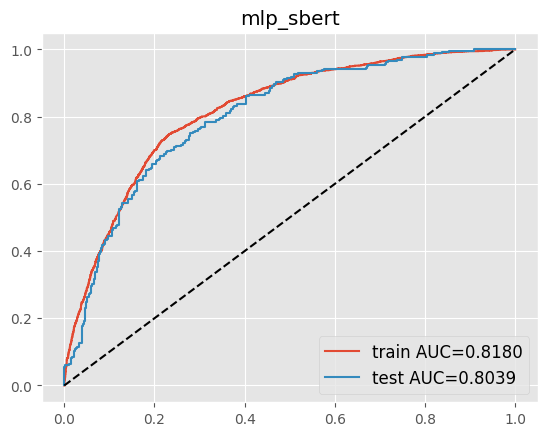

In [9]:
mlp = MLPClassifier(random_state=3, verbose=0)

param_grid = {'hidden_layer_sizes': [(4, 8, 16, 24)],
            'solver':['adam'],
            'activation': [ 'relu' ],
            'learning_rate': ['adaptive'],
            'early_stopping': [ True],
            'max_iter':[300],
            'learning_rate_init':[0.0002]
            }

gs = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2, return_train_score=True)

gs.fit(X_train_matrix, y_train_arr)

out_dict = visualize_and_save_results(gs, 'mlp_sbert', X_train_matrix, X_test_matrix, y_train, y_test, out_dict)
mlp_dict = get_metrics(gs, out_dict)
mlp_dict

___
###  $\uparrow$ [К содержанию](#100)